In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [ ]:
# Load dataset (make sure the path is correct)
df = pd.read_csv('/content/synthetic_rul_dataset.csv')
df.head()


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,RUL
0,64.967142,113.892663,96.792265,215.567222,26.624109,387.489942
1,58.617357,128.641250,91.095604,188.976286,29.277407,392.953081
2,66.476885,79.021486,80.715564,183.636022,26.037900,394.820152
3,75.230299,108.444539,72.236759,199.932511,28.460192,377.904442
4,57.658466,90.240361,88.378680,196.596308,20.531927,387.699016


In [ ]:
# Split into features and target
features = df.drop('RUL', axis=1)
target = df['RUL'].values.reshape(-1, 1)

# Normalize features and target using MinMaxScaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)


In [ ]:
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")


Training samples: (392, 10, 5), Testing samples: (98, 10, 5)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build a deeper LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0262 - mae: 0.1314 - val_loss: 0.0306 - val_mae: 0.1347 - learning_rate: 1.2500e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0229 - mae: 0.1228 - val_loss: 0.0307 - val_mae: 0.1349 - learning_rate: 1.2500e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0240 - mae: 0.1272 - val_loss: 0.0315 - val_mae: 0.1367 - learning_rate: 1.2500e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0246 - mae: 0.1270 - val_loss: 0.0299 - val_mae: 0.1328 - learning_rate: 1.2500e-04
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0254 - mae: 0.1230 - val_loss: 0.0307 - val_mae: 0.1349 - learning_rate: 1.2500e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0250 - mae: 0.1260 - val_loss: 0.0310 - val_mae: 0.1354 - learning_rate: 1.2500e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0231 - mae: 0.1188 - val_loss: 0.0310 - val_mae: 0.1355 - learning_ra

In [30]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE (normalized): {mae:.4f}")


Test MAE (normalized): 0.1035


In [33]:
# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Compare a few predictions
for i in range(5):
    print(f"Predicted RUL: {y_pred_original[i][0]:.2f}, Actual RUL: {y_test_original[i][0]:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted RUL: 393.14, Actual RUL: 387.82
Predicted RUL: 390.84, Actual RUL: 398.67
Predicted RUL: 392.75, Actual RUL: 392.26
Predicted RUL: 392.72, Actual RUL: 394.85
Predicted RUL: 392.19, Actual RUL: 380.55


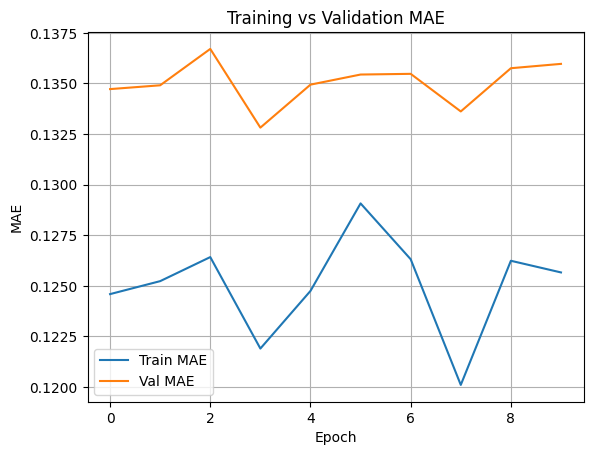

In [34]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training vs Validation MAE')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Predict on training data
y_train_pred = model.predict(X_train)
y_train_pred_original = target_scaler.inverse_transform(y_train_pred)
y_train_original = target_scaler.inverse_transform(y_train)

# Predict on testing data
y_test_pred = model.predict(X_test)
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calculate R² score for training and testing
train_r2 = r2_score(y_train_original, y_train_pred_original)
test_r2 = r2_score(y_test_original, y_test_pred_original)

print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training R² Score: -0.0078
Testing R² Score: -0.0060


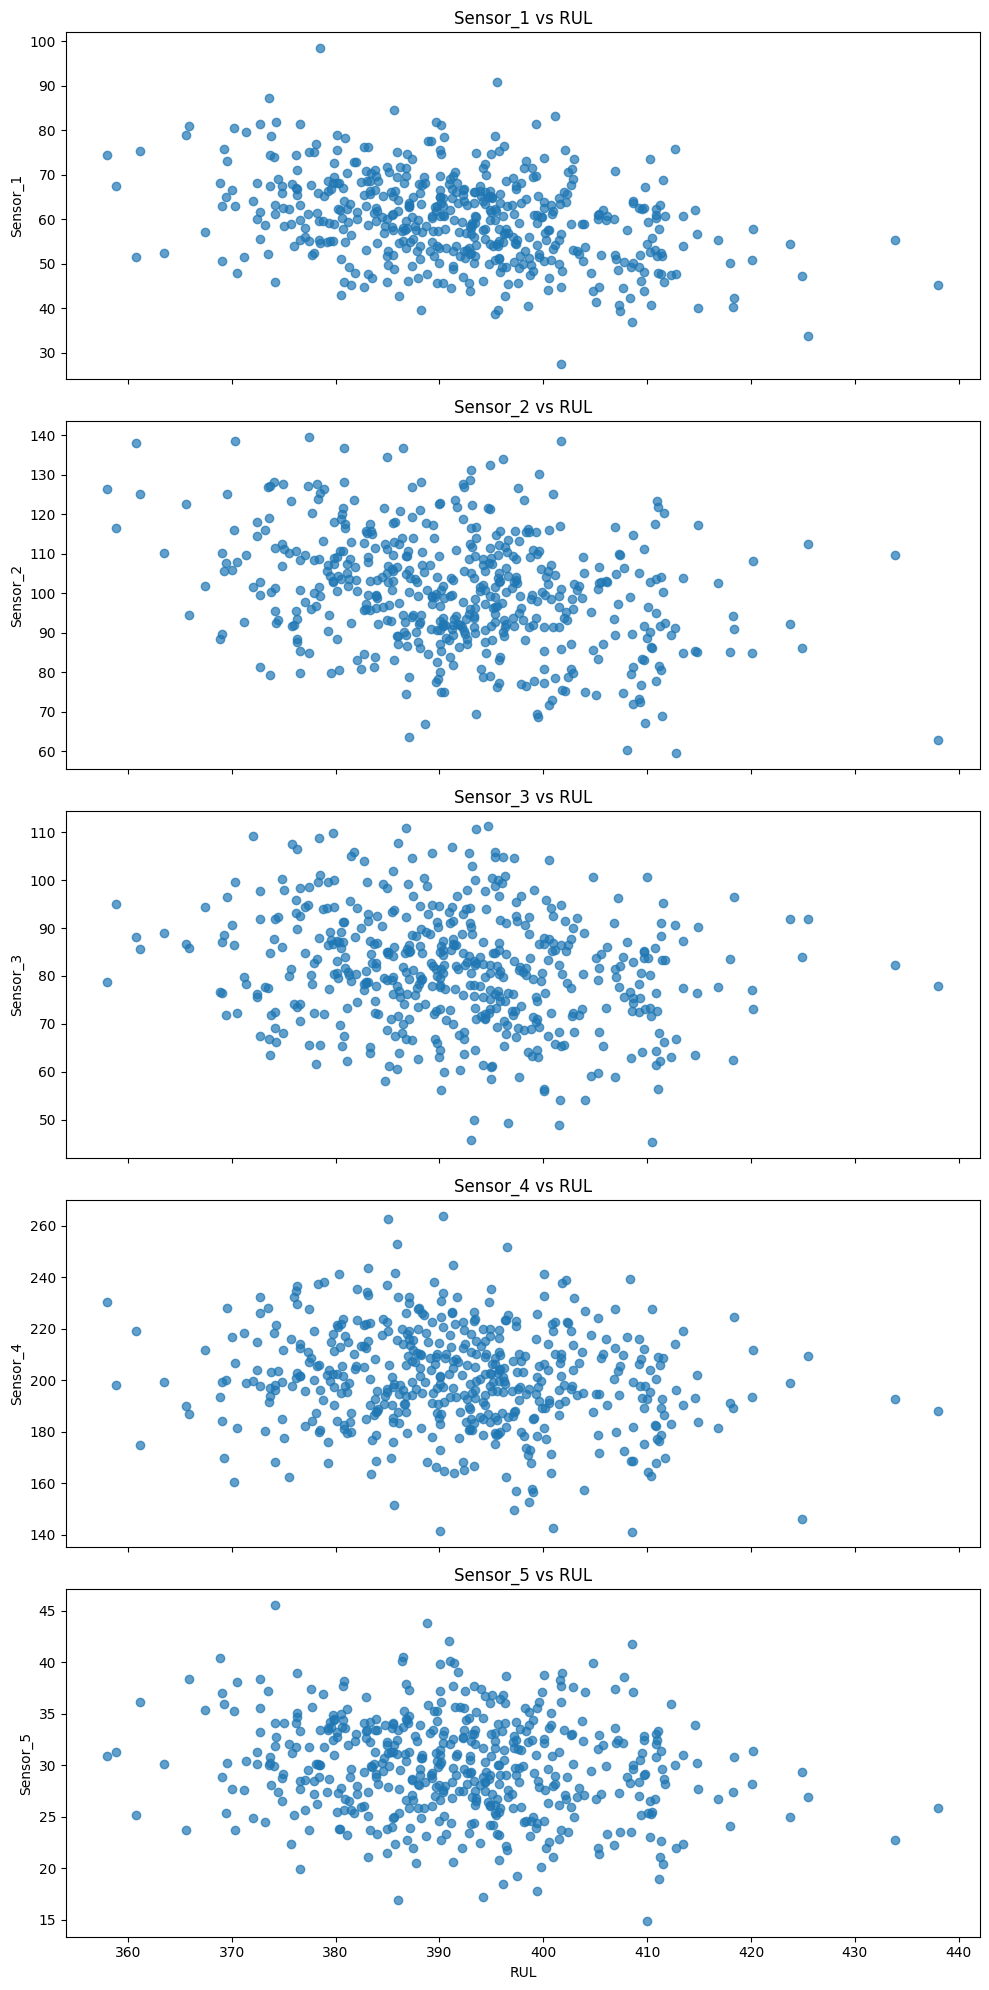

In [35]:
import matplotlib.pyplot as plt

sensors = ["Sensor_1", "Sensor_2", "Sensor_3", "Sensor_4", "Sensor_5"]
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

for i, sensor in enumerate(sensors):
    axs[i].scatter(df["RUL"], df[sensor], alpha=0.7)
    axs[i].set_ylabel(sensor)
    axs[i].set_title(f"{sensor} vs RUL")

axs[-1].set_xlabel("RUL")
plt.tight_layout()
plt.show()


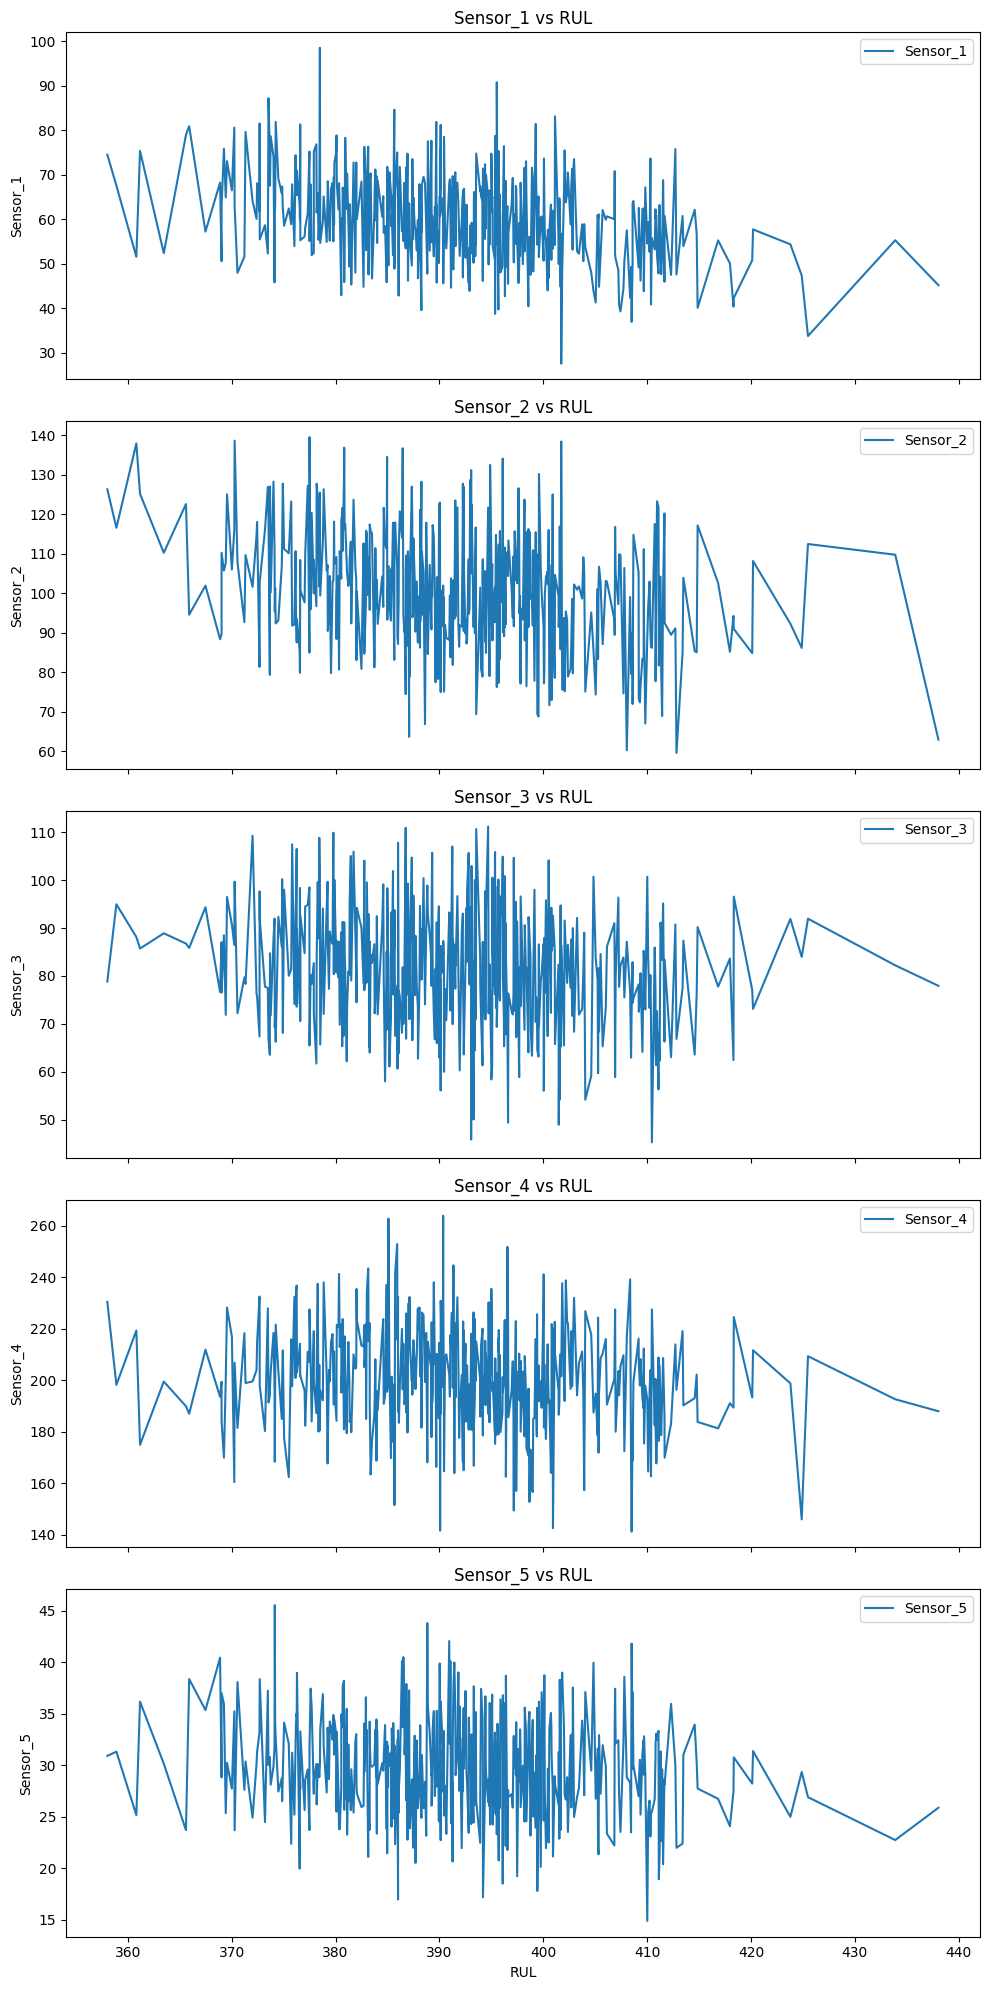

In [36]:
import matplotlib.pyplot as plt

sensors = ["Sensor_1", "Sensor_2", "Sensor_3", "Sensor_4", "Sensor_5"]
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

for i, sensor in enumerate(sensors):
    # Sort the DataFrame by RUL for a meaningful line plot
    sorted_df = df.sort_values("RUL")
    axs[i].plot(sorted_df["RUL"], sorted_df[sensor], label=sensor)
    axs[i].set_ylabel(sensor)
    axs[i].set_title(f"{sensor} vs RUL")
    axs[i].legend()

axs[-1].set_xlabel("RUL")
plt.tight_layout()
plt.show()


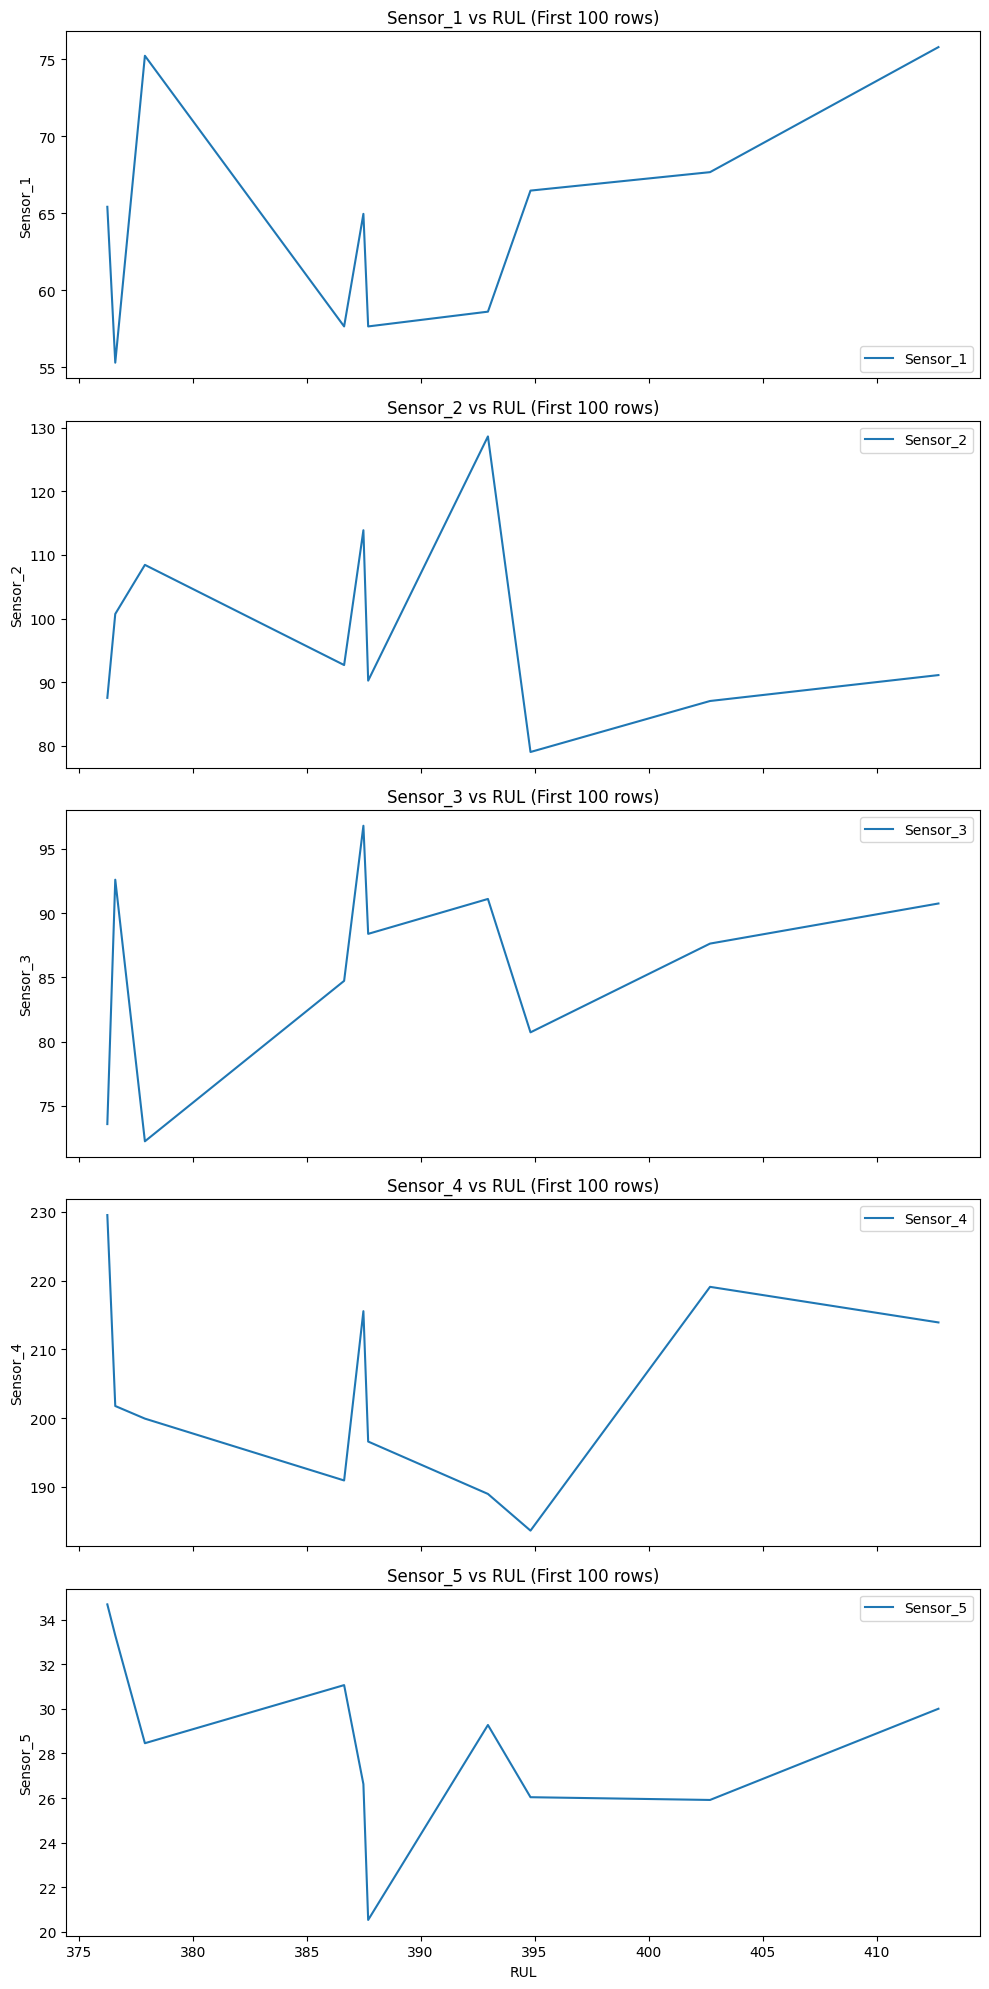

In [40]:
import matplotlib.pyplot as plt

# Use only the first 100 rows
subset_df = df.head(10)

sensors = ["Sensor_1", "Sensor_2", "Sensor_3", "Sensor_4", "Sensor_5"]
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

for i, sensor in enumerate(sensors):
    # Sort the subset by RUL for meaningful line plots
    sorted_df = subset_df.sort_values("RUL")
    axs[i].plot(sorted_df["RUL"], sorted_df[sensor], label=sensor)
    axs[i].set_ylabel(sensor)
    axs[i].set_title(f"{sensor} vs RUL (First 100 rows)")
    axs[i].legend()

axs[-1].set_xlabel("RUL")
plt.tight_layout()
plt.show()
